In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, ttest_1samp
import psycopg2
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sqlalchemy import create_engine 
import os
from dotenv import load_dotenv
load_dotenv("../../.env.postgres")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
conn = psycopg2.connect(
    database = "amazon_uk",
    user = os.environ["POSTGRES_USER"],
    password = os.environ["POSTGRES_PASSWORD"]
)

In [3]:
df = pd.read_sql("SELECT * FROM amazon_uk_2023_grocery;", conn)
df.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_1856\3938453409.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM amazon_uk_2023_grocery;", conn)


,index,asin,title,imgUrl,productURL,stars,reviews,price,isBestSeller,boughtInLastMonth,categoryName
0,1559638,B010DCXTO8,Windolene 4 Action Glass & Shiny Surfaces Wipe...,https://m.media-amazon.com/images/I/61s6bY+yXq...,https://www.amazon.co.uk/dp/B010DCXTO8,4.5,690,14.97,False,500,Grocery
1,1559639,B07DXYD83X,Hilltop Honey - Blossom Honey - Tub - 3.17kg,https://m.media-amazon.com/images/I/61ljs37m9M...,https://www.amazon.co.uk/dp/B07DXYD83X,4.1,218,14.49,False,500,Grocery
2,1559640,B00G9Y0T2U,"Bloo Max In Cistern Original, 70g",https://m.media-amazon.com/images/I/71AscHHd4R...,https://www.amazon.co.uk/dp/B00G9Y0T2U,4.4,629,1.85,False,500,Grocery
3,1559641,B00ISCQ8BM,Liberty Easy Cook Long Grain Rice 5KG,https://m.media-amazon.com/images/I/41H5S7OWGJ...,https://www.amazon.co.uk/dp/B00ISCQ8BM,4.6,24,6.00,False,600,Grocery
4,1559642,B07R8MHMFD,Biona Organic Pumpkin Seed Oil 250 ml - Cold P...,https://m.media-amazon.com/images/I/51tuU9N3Tg...,https://www.amazon.co.uk/dp/B07R8MHMFD,4.3,699,6.39,False,600,Grocery


In [4]:
conn.close()

In [5]:
conn_string = os.environ.get("POSTGRES_CONN")
conn = create_engine(conn_string) 

Analyze the statistics

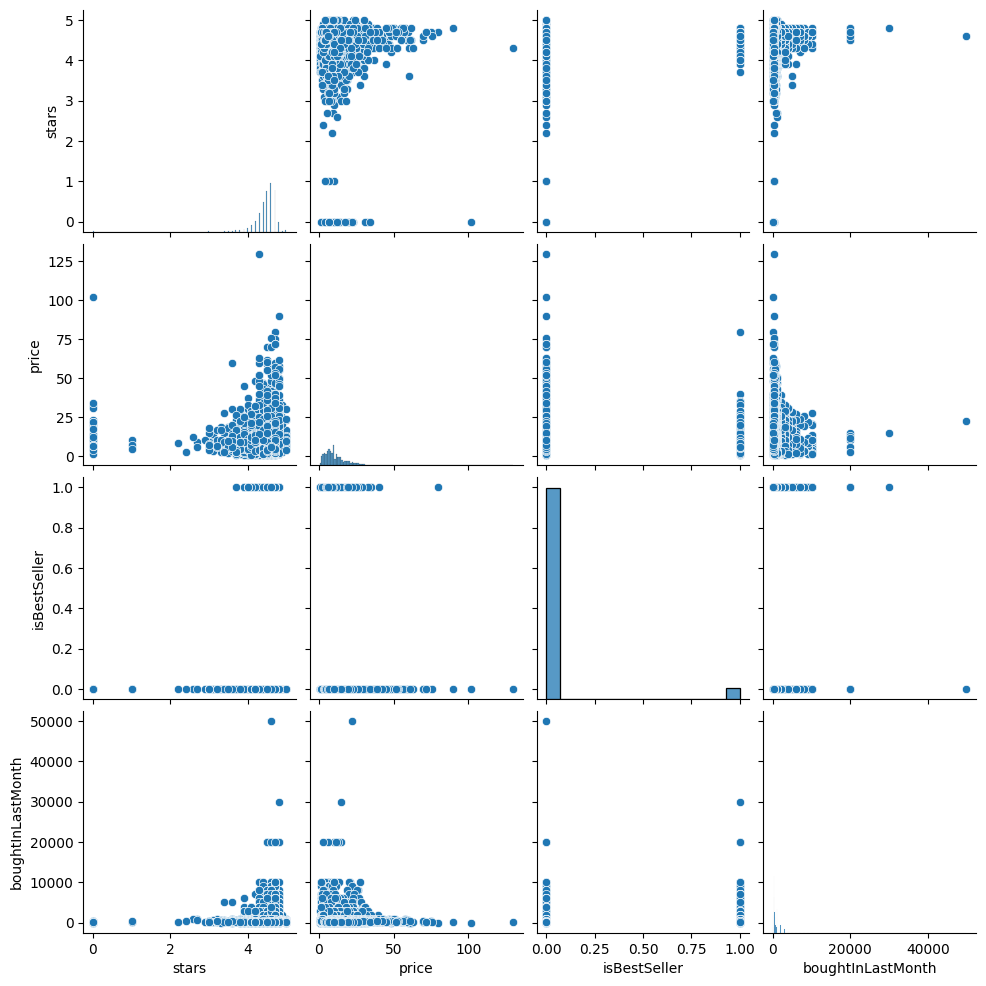

In [6]:
sns.pairplot(df[["stars", "price", "isBestSeller", "boughtInLastMonth"]])

In [7]:
df[df["boughtInLastMonth"] > 1000].shape[0] / df.shape[0]

0.07870001593117731

In [8]:
df["moreBought"] = df["boughtInLastMonth"] > 1000

<Axes: xlabel='moreBought', ylabel='stars'>

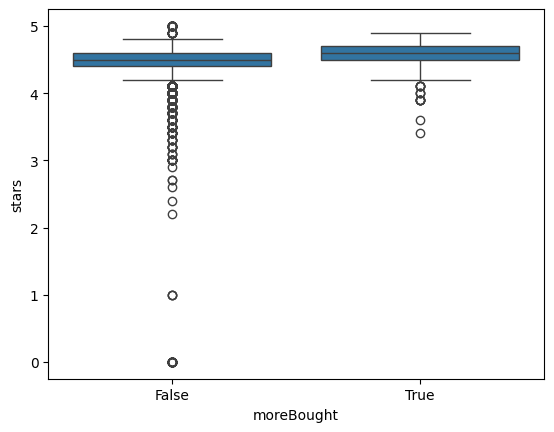

In [9]:
sns.boxplot(df, x = "moreBought", y = "stars")

<Axes: xlabel='moreBought', ylabel='price'>

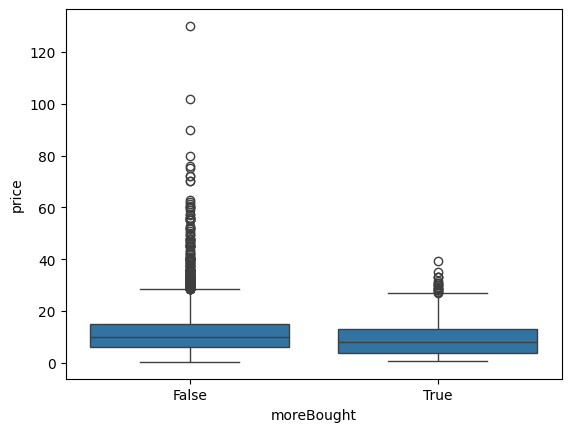

In [10]:
sns.boxplot(df, x = "moreBought", y = "price")

In [11]:
# t-test for means of Stars between 2 groups
stars_more_bought = np.array(df[df["moreBought"]]["stars"])
stars_less_bought = np.array(df[~df["moreBought"]]["stars"])
t_test_res = ttest_ind(stars_more_bought, stars_less_bought, equal_var = False)
print("Result for Welch's t-test for difference in means of stars ratings of more bought vs. less bought group")
print(f"t-statistics: {t_test_res.statistic}")
print(f"p-value: {t_test_res.pvalue}")
ci = t_test_res.confidence_interval()
print("CI for difference in means of star ratings of more bought vs. less bought group")
print(f"({ci.low}, {ci.high})")

Result for Welch's t-test for difference in means of stars ratings of more bought vs. less bought group
t-statistics: 11.517253315643817
p-value: 7.022028921139924e-29
CI for difference in means of star ratings of more bought vs. less bought group
(0.09691802901326335, 0.13672812497290648)


In [12]:
# t-test for means of Stars between 2 groups
price_more_bought = np.array(df[df["moreBought"]]["price"])
price_less_bought = np.array(df[~df["moreBought"]]["price"])
t_test_res = ttest_ind(price_more_bought, price_less_bought, equal_var = False)
print("Result for Welch's t-test for difference in means of price of more bought vs. less bought group")
print(f"t-statistics: {t_test_res.statistic}")
print(f"p-value: {t_test_res.pvalue}")
ci = t_test_res.confidence_interval()
print("CI for difference in means of price of more bought vs. less bought group")
print(f"({ci.low}, {ci.high})")

Result for Welch's t-test for difference in means of price of more bought vs. less bought group
t-statistics: -4.807109651962926
p-value: 1.930397088115953e-06
CI for difference in means of price of more bought vs. less bought group
(-2.4025607600307812, -1.008878618687095)


In [13]:
t_test_res = ttest_1samp(np.array(df["price"]), 0)
ci = t_test_res.confidence_interval()
print("CI for means of price of Health & Personal Care product")
print(f"({ci.low}, {ci.high})")

CI for means of price of Health & Personal Care product
(11.370584400900732, 11.793022417643162)


Price are slightly lower, but if significantly more people bought it => profit

In [14]:
# plot words from products that has someone bought
more_bought_df = df[df["moreBought"]]
more_bought_title_all = " ".join(more_bought_df["title"]).lower()
# Preprocess to remove non alphabet character and excess spaces
more_bought_title_all = re.sub(r'[^a-zA-Z\s]', '', more_bought_title_all)
more_bought_title_all = re.sub(r'\s+', ' ', more_bought_title_all).strip()
# Get all words
more_bought_title_words = more_bought_title_all.split()
# remove stopwords
more_bought_title_words = [w for w in more_bought_title_words if w not in stop_words]
# Set up counter
more_bought_title_words_counter = {}
for w in more_bought_title_words:
    more_bought_title_words_counter[w] = more_bought_title_words_counter.get(w, 0) + 1
# Make the dataframe for this
more_bought_title_words_counter_t = {"word": [], "count": []}
for w in more_bought_title_words_counter:
    more_bought_title_words_counter_t["word"].append(w)
    more_bought_title_words_counter_t["count"].append(more_bought_title_words_counter[w])
more_bought_title_words_df = pd.DataFrame(more_bought_title_words_counter_t)
more_bought_title_words_df = more_bought_title_words_df.sort_values("count", ascending = False).reset_index().drop("index", axis = 1)
more_bought_title_words_df.head()

,word,count
0,pack,149
1,ml,125
2,x,114
3,coffee,107
4,g,96


In [15]:
# plot words from products that no one bought
less_bought_df = df[~df["moreBought"]]
less_bought_title_all = " ".join(less_bought_df["title"]).lower()
# Preprocess to remove non alphabet character and excess spaces
less_bought_title_all = re.sub(r'[^a-zA-Z\s]', '', less_bought_title_all)
less_bought_title_all = re.sub(r'\s+', ' ', less_bought_title_all).strip()
# Get all words
less_bought_title_words = less_bought_title_all.split()
# remove stopwords
less_bought_title_words = [w for w in less_bought_title_words if w not in stop_words]
# Set up counter
less_bought_title_words_counter = {}
for w in less_bought_title_words:
    less_bought_title_words_counter[w] = less_bought_title_words_counter.get(w, 0) + 1
# Make the dataframe for this
less_bought_title_words_counter_t = {"word": [], "count": []}
for w in less_bought_title_words_counter:
    less_bought_title_words_counter_t["word"].append(w)
    less_bought_title_words_counter_t["count"].append(less_bought_title_words_counter[w])
less_bought_title_words_df = pd.DataFrame(less_bought_title_words_counter_t).sort_values("count", ascending = False).reset_index().drop("index", axis = 1)
less_bought_title_words_df.head()

,word,count
0,g,1658
1,pack,1428
2,x,1098
3,ml,1059
4,free,664


In [16]:
only_more_bought = more_bought_title_words_df.merge(less_bought_title_words_df, how = "left", on = "word")
only_more_bought = only_more_bought[only_more_bought["count_y"].isna()]
only_more_bought

,word,count_x,count_y
390,quilts,3,NaN
536,thats,2,NaN
539,interdental,2,NaN
551,edges,2,NaN
552,perforated,2,NaN
...,...,...,...
1800,vimto,1,NaN
1806,voltesso,1,NaN
1807,diavollito,1,NaN
1812,jung,1,NaN


In [17]:
only_less_bought = less_bought_title_words_df.merge(more_bought_title_words_df, how = "left", on = "word")
only_less_bought = only_less_bought[only_less_bought["count_y"].isna()]
only_less_bought

,word,count_x,count_y
103,gmo,100,NaN
119,edible,90,NaN
160,jar,73,NaN
177,teabags,68,NaN
194,earth,62,NaN
...,...,...,...
8427,gnaw,1,NaN
8428,fudgy,1,NaN
8429,rocky,1,NaN
8430,thinned,1,NaN


In [18]:
# Save these notable words data to postgres
only_more_bought = only_more_bought[["word", "count_x"]]
only_more_bought = only_more_bought.rename({"count_x": "count"}, axis = 1)
only_more_bought = only_more_bought.reset_index().drop("index", axis = 1)
only_more_bought.to_sql("amazon_uk_2023_grocery_product_more_bought_word", conn, if_exists = "replace")

215

In [19]:
# Save these notable words data to postgres
only_less_bought = only_less_bought[["word", "count_x"]]
only_less_bought = only_less_bought.rename({"count_x": "count"}, axis = 1)
only_less_bought = only_less_bought.reset_index().drop("index", axis = 1)
only_less_bought.to_sql("amazon_uk_2023_grocery_product_less_bought_word", conn, if_exists = "replace")

818